# AR,MA,ARMA,ARIMA,Prophet,LSTM + MultiReg Models with WTI dataset
I will try to predict with using various time series forecasting models.

# Importing the libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.core import Activation
import tensorflow as tf
from keras.initializers import glorot_uniform

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import random
from numpy.random import seed

import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'sklearn'

In [2]:
pip install sklearn

  Using cached sklearn-0.0.post5.tar.gz (3.7 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  
  If the previous advice does not cover your use 

# Common function

In [2]:
def show_graph(train, test=None, pred=None, title=None):
    
    fig = plt.figure(figsize=(20, 5))

    # entire data
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel('Dates')
    ax1.set_ylabel('Price')
    ax1.plot(train.index, train['Price'], color='green', label='Train price')
    if test is not None:
        ax1.plot(test.index, test['Price'], color='red', label='Test price')
    if pred is not None:
        if 'yhat' in pred.columns:
            ax1.plot(pred.index, pred['yhat'], color = 'blue', label = 'Predicted price')
            ax1.fill_between(pred.index, pred['yhat_lower'], pred['yhat_upper'], color='grey', label="Band Range")
        else:
            ax1.plot(pred.index, pred['Price'], color='blue', label='Predicted price')
    ax1.legend()
    if title is not None:
        plt.title(title + ' (Entire)')
    plt.grid(True)

    # zoom data
    period=50
    period=int(0.2*len(train))
    ax2 = fig.add_subplot(122)
    ax2.set_xlabel('Dates')
    ax2.set_ylabel('Price')
    ax2.plot(train.index[-period:], train['Price'].tail(period), color='green', label='Train price')
    if test is not None:
        ax2.plot(test.index, test['Price'], color='red', label='Test price')
    if pred is not None:
        if 'yhat' in pred.columns:
            ax2.plot(pred.index, pred['yhat'], color = 'blue', label = 'Predicted price')
            ax2.fill_between(pred.index, pred['yhat_lower'], pred['yhat_upper'], color='grey', label="Band Range")
        else:
            ax2.plot(pred.index, pred['Price'], color='blue', label='Predicted price')
    ax2.legend()
    if title is not None:
        plt.title(title + ' (Recent ' + str(period) + ')')
    plt.grid(True)

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def make_future_dates(last_date, period):
    prediction_dates=pd.date_range(last_date, periods=period+1, freq='B')
    return prediction_dates[1:]

def calculate_accuracy(forecast, actual, algorithm):
    mse  = round(mean_squared_error(actual, forecast),4)
    mae  = round(mean_absolute_error(actual, forecast),4)
    rmse = round(sqrt(mean_squared_error(actual, forecast)),4)
    return ({'algorithm':algorithm, 'mse':mse, 'mae':mae, 'rmse': rmse})

# Loading WTI oil dataset

In [3]:
def get_data_from_EIA_local():
    df = pd.read_csv("../input/cushing-ok-wti-spot-price-fob/Cushing_OK_WTI_Spot_Price_FOB_20200706.csv", header=4, parse_dates=[0])
    df.columns=["Date", "Price"]
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    return df

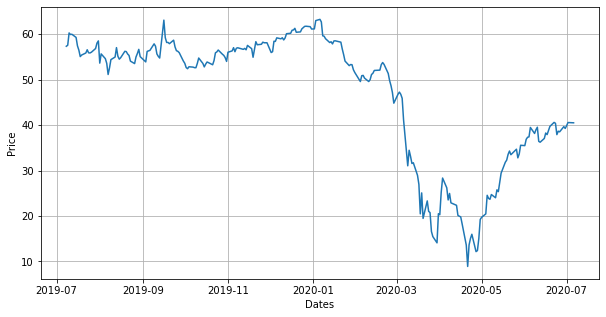

In [4]:
df_org=get_data_from_EIA_local()
data=df_org['2019-07-06':'2020-07-06'].copy()
data.Price["2020-04-20"]=(data.Price["2020-04-17"] + data.Price["2020-04-21"]) / 2

acc_sum=[]
df_preds=pd.DataFrame({"Date":make_future_dates('2020-07-06',34)})
df_preds=df_preds.set_index('Date', drop=True)

# Display OIL price
plt.figure(figsize=(10,5))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(data['Price']);
plt.grid(True)
plt.show()

# Data Analysis

### Autocorrelation plot

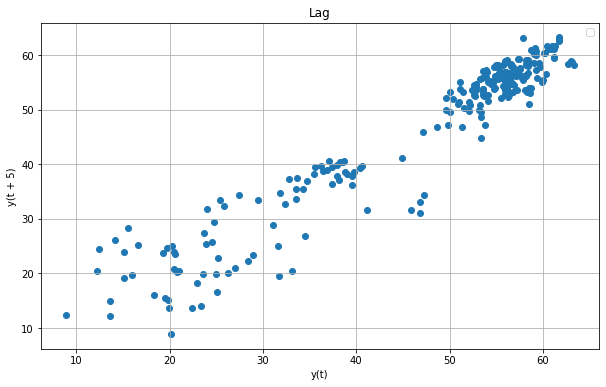

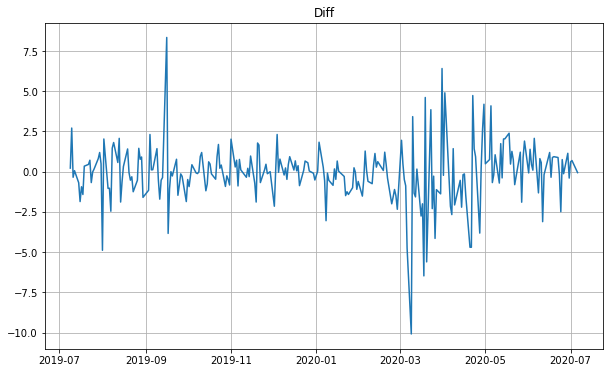

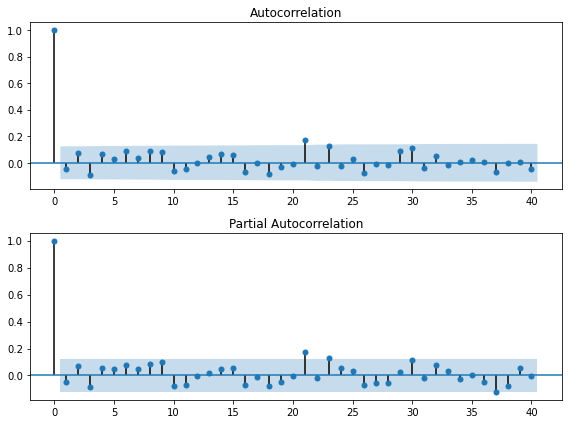

In [5]:
# Show LAG
fig = plt.figure(figsize=(10, 6))
lag_plot(data['Price'], lag=5)
plt.title('Lag')
plt.grid(True)
plt.legend();

# Show Diff
data_diff = data - data.shift() 
data_diff = data_diff.dropna()
plt.figure(figsize=(10, 6))
plt.title('Diff')
plt.grid(True)
plt.plot(data_diff);

fig = plt.figure(figsize=(8, 6))

# Show ACF
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(data_diff, lags=40, ax=ax1)

# Show PACF
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(data_diff, lags=40, ax=ax2)

plt.tight_layout()

### Seasonal decompose

<Figure size 1152x720 with 0 Axes>

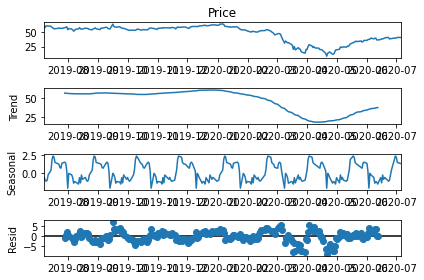

In [6]:
result = seasonal_decompose(data.Price[-1000:], model='additive', freq=30)
plt.figure(figsize=(16,10))
fig = result.plot()
plt.show()

In [7]:
values = DataFrame(data['Price'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.967239  0.914819  0.626353  0.991485
t+1   0.967239  1.000000  0.958620  0.690879  0.958659
t+5   0.914819  0.958620  1.000000  0.765527  0.900565
t+10  0.626353  0.690879  0.765527  1.000000  0.609086
t+30  0.991485  0.958659  0.900565  0.609086  1.000000


### ADF test

In [8]:
adf_result = sm.tsa.stattools.adfuller(data['Price'].values, autolag ='AIC')
adf = pd.Series(adf_result[0:4], index = ['Test Statistic', 'p-　　value', '#Lags Used', 'Number of Observations Used'])
print(adf)

Test Statistic                  -1.123380
p-　　value                        0.705659
#Lags Used                       0.000000
Number of Observations Used    250.000000
dtype: float64


# Train-Test Split

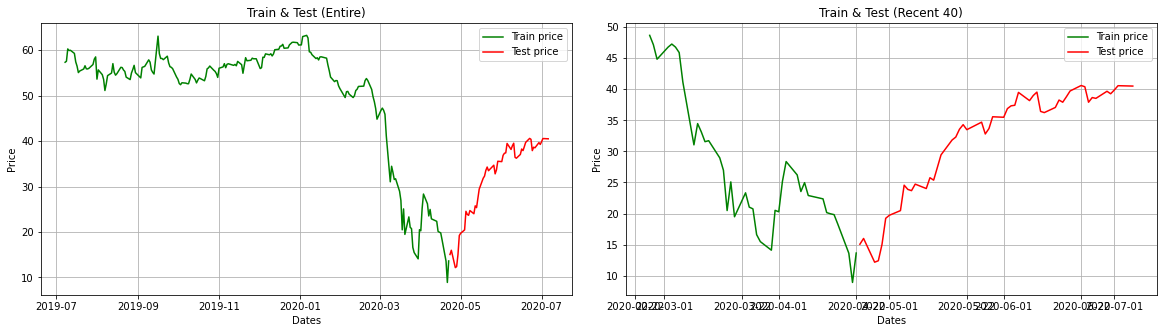

In [9]:
split = int(0.80*len(data))
train_data, test_data = data[0:split], data[split:]
show_graph(train_data,test_data,title='Train & Test')

# Common function for AR,MA,ARMA,ARIMA

In [10]:
def evaluate_arima_model(train, test, order, maxlags=8, ic='aic'):
    # feature Scaling
    stdsc = StandardScaler()
    train_std = stdsc.fit_transform(train.values.reshape(-1, 1))
    test_std = stdsc.transform(test.values.reshape(-1, 1))
    # prepare training dataset
    history = [x for x in train_std]
    # make predictions
    predictions = list()
    # rolling forecasts
    for t in range(len(test_std)):
        # predict
        model = ARIMA(history, order=order)
        model_fit = model.fit(maxlags=maxlags, ic=ic, disp=0)
        yhat = model_fit.forecast()[0]
        # invert transformed prediction
        predictions.append(yhat)
        # observation
        history.append(test_std[t])
    # inverse transform
    predictions = stdsc.inverse_transform(np.array(predictions).reshape((-1)))
    # calculate mse
    mse = mean_squared_error(test, predictions)
    return predictions, mse

def evaluate_arima_models(train, test, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    pdq = list(itertools.product(p_values, d_values, q_values))
    for order in pdq:
        try:
            predictions, mse = evaluate_arima_model(train, test, order)
            if mse < best_score:
                best_score, best_cfg = mse, order
            print('Model(%s) mse=%.3f' % (order,mse))
        except:
            continue
    print('Best Model(%s) mse=%.3f' % (best_cfg, best_score)) 
    return best_cfg

def predict_arima_model(train, period, order, maxlags=8, ic='aic'):
    # Feature Scaling
    stdsc = StandardScaler()
    train_std = stdsc.fit_transform(train.values.reshape(-1, 1))
    # fit model
    model = ARIMA(train_std, order=order)
    model_fit = model.fit(maxlags=maxlags, ic=ic, disp=0)
    # make prediction
    yhat = model_fit.predict(len(train), len(train) + period -1, typ='levels')
    # inverse transform
    yhat = stdsc.inverse_transform(np.array(yhat).flatten())
    return yhat

# AR
ARIMA(p) is AR model.

{'algorithm': 'AR Model', 'mse': 2.3029, 'mae': 1.1457, 'rmse': 1.5175}


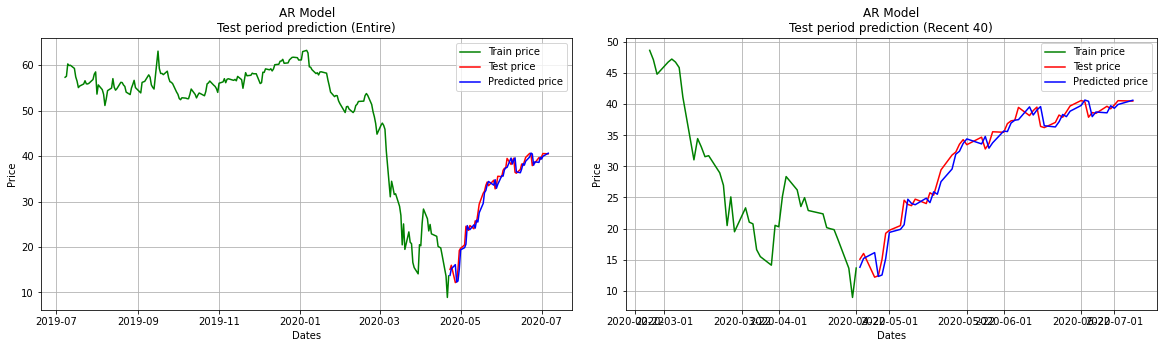

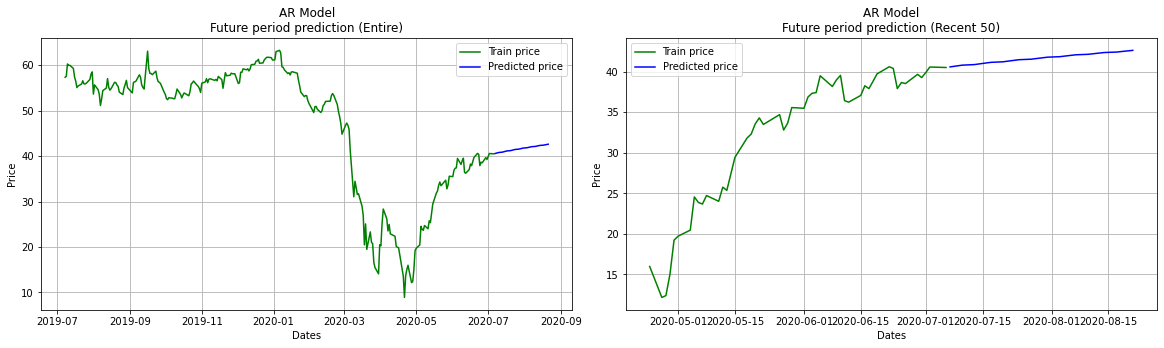

In [11]:
model_name='AR Model'

# evaluate parameters
p_values = range(1, 4)
d_values = [0]
q_values = [0]
#evaluate_arima_models(train_data['Price'], test_data['Price'], p_values, d_values, q_values)

# predict test period with best parameter
predictions, mse = evaluate_arima_model(train_data['Price'], test_data['Price'],(1, 0, 0))
df_pred = pd.DataFrame({'Price':predictions},index=test_data.index)

# calculate performance metrics
acc = calculate_accuracy(predictions, test_data['Price'], model_name)
print(acc)
acc_sum.append(acc)

# show result
show_graph(train_data,test_data,df_pred,title=model_name+'\nTest period prediction')

# predict future period with best parameter
forecast_out = 34
future_dates = make_future_dates(data.index[-1], forecast_out)
predictions = predict_arima_model(data,len(future_dates),(1, 0, 0))
df_pred = pd.DataFrame({'Price':predictions},index=future_dates)

# show result
show_graph(data,None,df_pred,title=model_name+'\nFuture period prediction')

df_preds[model_name] = df_pred['Price']

# MA
ARIMA(q) is MA model.

{'algorithm': 'MA Model', 'mse': 94.8854, 'mae': 8.3008, 'rmse': 9.7409}


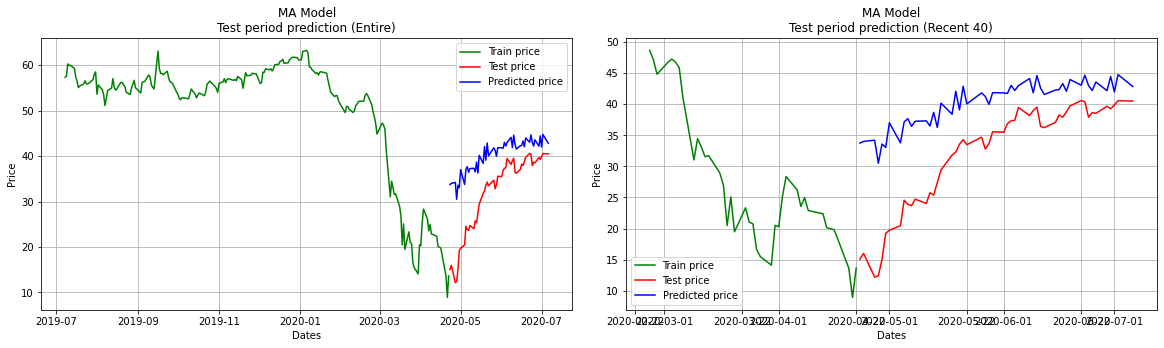

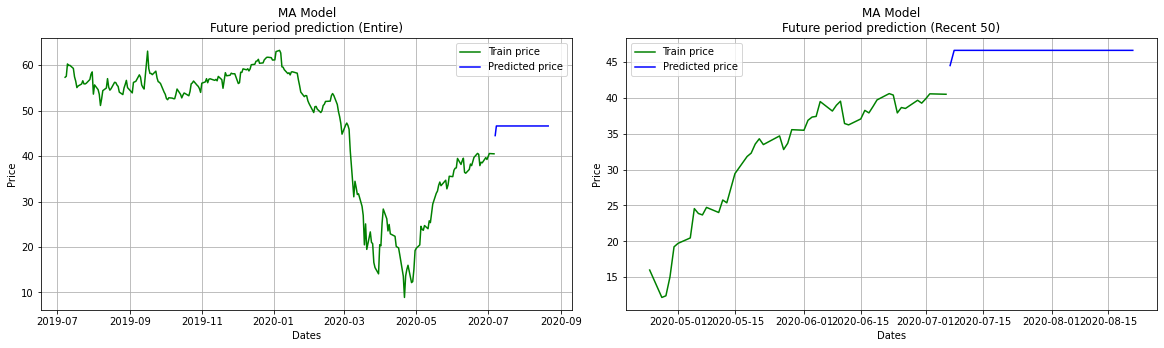

In [12]:
model_name='MA Model'

# evaluate parameters
p_values = [0]
d_values = [0]
q_values = range(1, 4)
#evaluate_arima_models(train_data['Price'], test_data['Price'], p_values, d_values, q_values)

# predict test period with best parameter
predictions, mse = evaluate_arima_model(train_data['Price'], test_data['Price'],(0, 0, 1))
df_pred = pd.DataFrame({'Price':predictions},index=test_data.index)

# calculate performance metrics
acc = calculate_accuracy(predictions, test_data['Price'], model_name)
print(acc)
acc_sum.append(acc)

# show result
show_graph(train_data, test_data, df_pred, title=model_name + '\nTest period prediction')

# predict future period with best parameter
forecast_out = 34
future_dates = make_future_dates(data.index[-1], forecast_out)
predictions = predict_arima_model(data,len(future_dates),(0, 0, 1))
df_pred = pd.DataFrame({'Price':predictions},index=future_dates)

# show result
show_graph(data,None,df_pred,title=model_name+'\nFuture period prediction')

df_preds[model_name] = df_pred['Price']

# ARMA
ARIMA(p, q) is ARMA model.

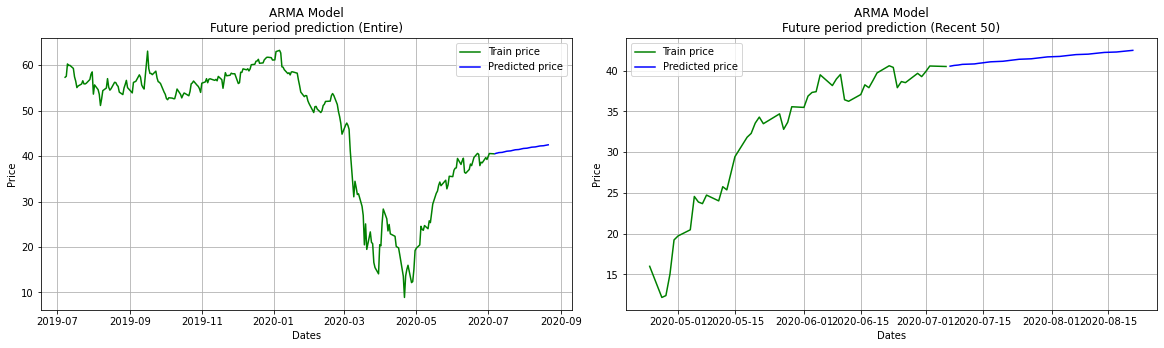

In [13]:
model_name='ARMA Model'

# evaluate parameters
p_values = range(0, 1, 2)
d_values = [0]
q_values = range(0, 1, 2)
#evaluate_arima_models(train_data['Price'].tail, test_data['Price'], p_values, d_values, q_values)

# predict test period with best parameter
#predictions, mse = evaluate_arima_model(train_data['Price'], test_data['Price'],(1, 0, 1))
#df_pred = pd.DataFrame({'Price':predictions},index=test_data.index)

## calculate performance metrics
#acc = calculate_accuracy(predictions, test_data['Price'], model_name)
#print(acc)
#acc_sum.append(acc)

# show result
#show_graph(train_data, test_data, df_pred, title=model_name + '\nTest period prediction')

# predict future period with best parameter
forecast_out = 34
future_dates = make_future_dates(data.index[-1], forecast_out)
predictions = predict_arima_model(data,len(future_dates),(2, 0, 1))
df_pred = pd.DataFrame({'Price':predictions},index=future_dates)

# show result
show_graph(data,None,df_pred,title=model_name+'\nFuture period prediction')

df_preds[model_name] = df_pred['Price']

# ARIMA
ARIMA(p, d, q) is ARIMA model.

{'algorithm': 'ARIMA Model', 'mse': 2.7074, 'mae': 1.2463, 'rmse': 1.6454}


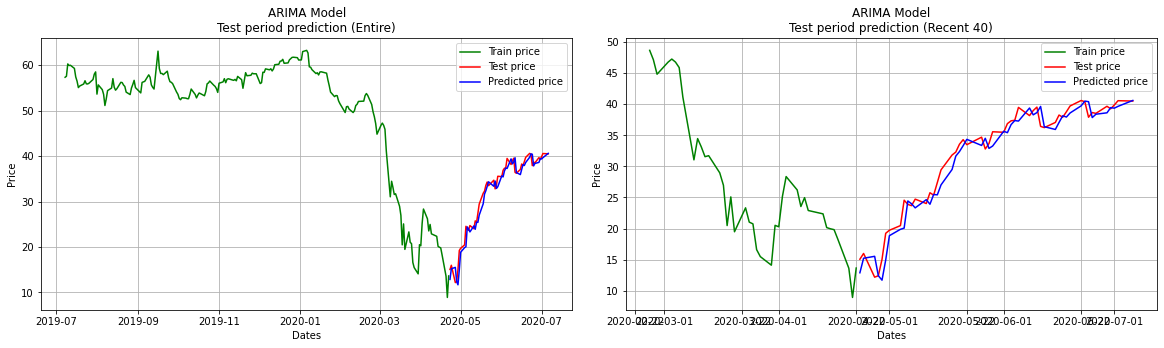

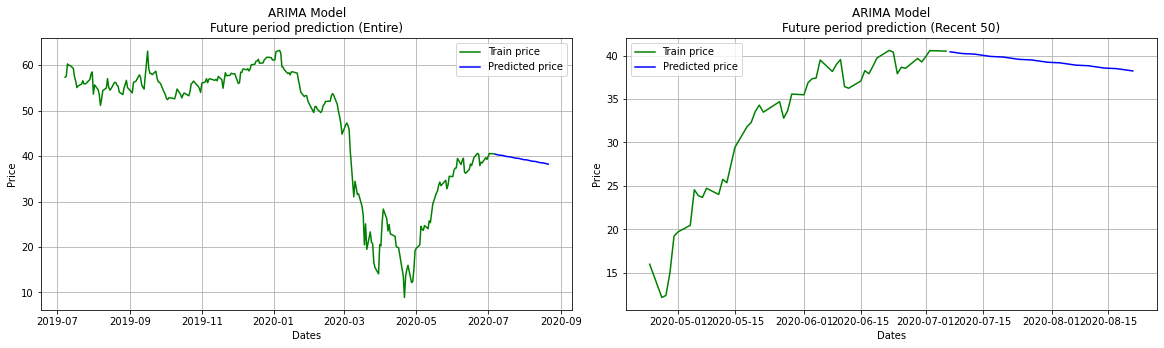

In [14]:
model_name='ARIMA Model'

# evaluate parameters
p_values = [1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(1, 3)
#evaluate_arima_models(train_data['Price'], test_data['Price'], p_values, d_values, q_values)

# predict test period with best parameter
predictions, mse = evaluate_arima_model(train_data['Price'], test_data['Price'],(2, 1, 1))
df_pred = pd.DataFrame({'Price':predictions},index=test_data.index)

# calculate performance metrics
acc = calculate_accuracy(predictions, test_data['Price'],model_name)
print(acc)
acc_sum.append(acc)

# show result
show_graph(train_data, test_data, df_pred, title=model_name + '\nTest period prediction')

# predict future period with best parameter
forecast_out = 34
future_dates = make_future_dates(data.index[-1], forecast_out)
predictions = predict_arima_model(data,len(future_dates),(2, 1, 1))
df_pred = pd.DataFrame({'Price':predictions},index=future_dates)

# show result
show_graph(data,None,df_pred,title=model_name+'\nFuture period prediction')

df_preds[model_name] = df_pred['Price']

# Facebook Prophet

{'algorithm': 'Facebook Prophet', 'mse': 588.4472, 'mae': 21.8356, 'rmse': 24.2579}


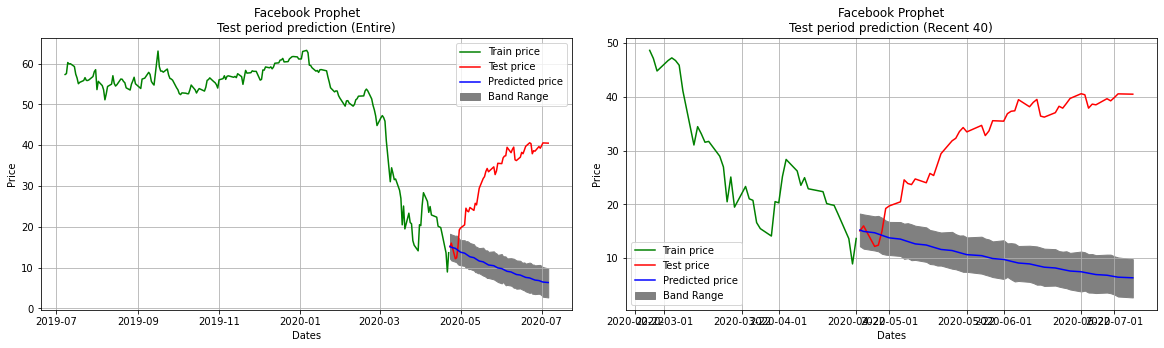

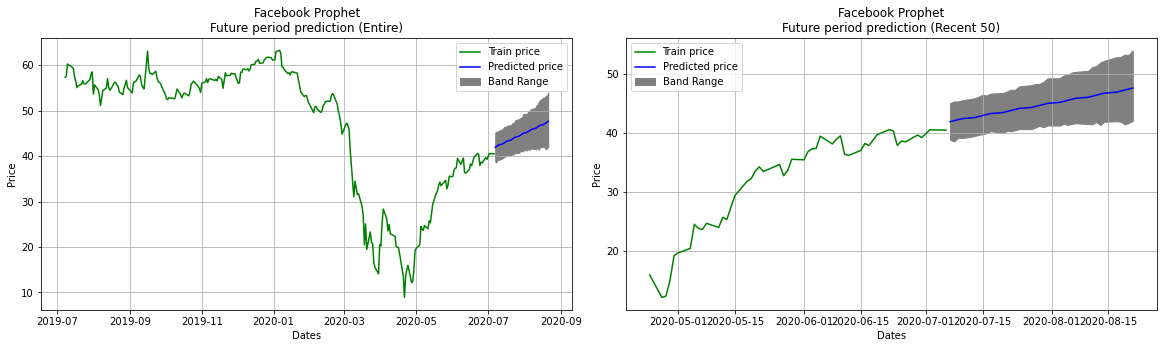

In [15]:
model_name='Facebook Prophet'

def predict_prophet(train,period):
    # create model
    prop = Prophet(growth='logistic',
                    n_changepoints=40,
                    changepoint_range=1,
                    changepoint_prior_scale=0.5,
                    weekly_seasonality=False,
                    yearly_seasonality=False
                  )
    # prepare training dataset
    ph_df_train = pd.DataFrame({'y':train['Price'].values, 'ds':train.index})
    ph_df_train['cap'] = 100
    ph_df_train['floor'] = 0
    prop.fit(ph_df_train)
    # create future dates
    future_prices = prop.make_future_dataframe(periods=period, freq = 'd')
    future_prices['cap'] = 100
    future_prices['floor'] = 0
    # predict prices
    forecast = prop.predict(future_prices)
    predicted=forecast[-period:]
    return predicted

# predict test period
predictions = predict_prophet(train_data,len(test_data))
predictions.index = test_data.index

# calculate performance metrics
acc = calculate_accuracy(predictions['yhat'], test_data['Price'], model_name)
print(acc)
acc_sum.append(acc)

# show result
show_graph(train_data, test_data, predictions, title=model_name + '\nTest period prediction')

# predict future period
forecast_out = 34
future_dates = make_future_dates(data.index[-1], forecast_out)
predictions = predict_prophet(data,len(future_dates))
predictions.index = future_dates

# show result
show_graph(data,None,predictions,title=model_name+'\nFuture period prediction')

df_preds[model_name] = predictions['yhat']

# LSTM

In [16]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def create_lstm_data(train,test,look_back):
    train_lstm = train
    test_lstm = test
    train_gen = TimeseriesGenerator(train_lstm, train_lstm, length=look_back, batch_size=20)     
    test_gen = TimeseriesGenerator(test_lstm, test_lstm, length=look_back, batch_size=1)
    return train_gen, test_gen

def create_lstm_model(neurons, activ_func="linear",
                dropout=0.10, loss="mean_squared_error", optimizer="adam"):
    set_random_seed(20200715)
    model = Sequential()
    
    model.add(LSTM(neurons,
                   input_shape=(look_back,1),
                   kernel_initializer=glorot_uniform(seed=20200715)
                  ))
    model.add(Dropout(dropout))
    model.add(Dense(units=1,
                   kernel_initializer=glorot_uniform(seed=20200715)
                  ))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

def predict_lstm_model(data, period, model):
    prediction_list = data[-look_back:]
    
    for _ in range(period):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
        
    prediction_list = prediction_list[look_back-1:]
    prediction_list = prediction_list[1:]
    return prediction_list

def show_lstm_history(history):
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss,  label='Training loss')
    plt.title('validation loss')
    plt.legend()
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               362400    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 0s 15ms/step - loss: 0.2090
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1717
Epoch 3/100
10/10 [==============================] - 0s 14ms/step - loss: 0.3167
Epoch

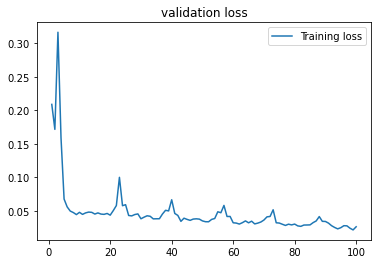

In [17]:
# feature Scaling
stdsc = StandardScaler()
train_lstm = stdsc.fit_transform(train_data.values.reshape(-1, 1))
test_lstm = stdsc.transform(test_data.values.reshape(-1, 1))

# create data
look_back = 7
train_gen, test_gen = create_lstm_data(train_lstm, test_lstm, look_back)

# create model
model = create_lstm_model(300)
model.summary()

# training
history = model.fit_generator(train_gen, epochs=100, verbose=1, shuffle=False)
show_lstm_history(history)

{'algorithm': 'LSTM', 'mse': 12.2598, 'mae': 2.8816, 'rmse': 3.5014}


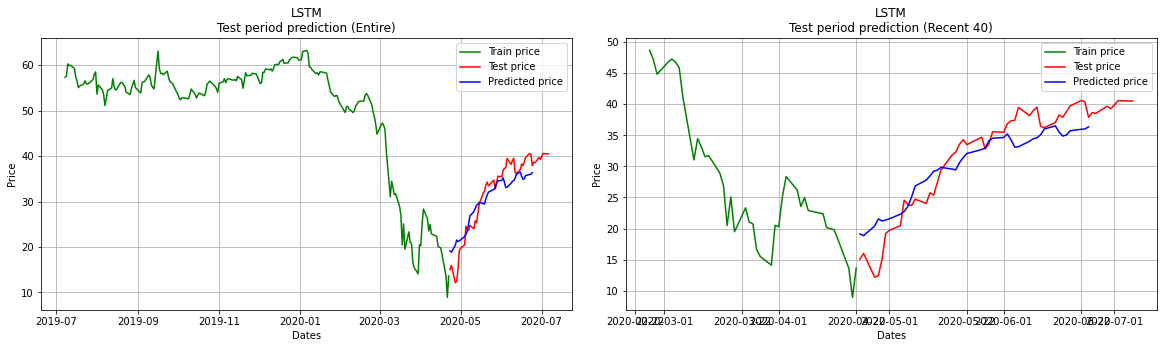

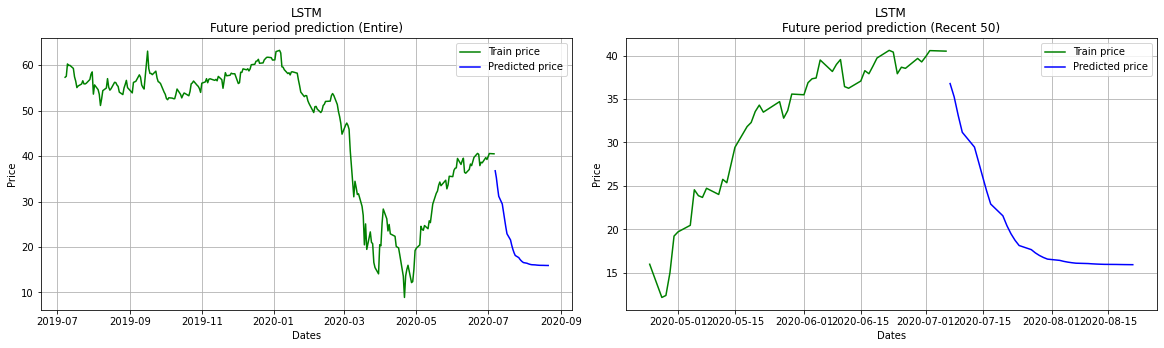

In [18]:
model_name='LSTM'

# predict test period
prediction = model.predict_generator(test_gen)

# inverse transform
prediction = stdsc.inverse_transform(prediction.reshape((-1)))
df_pred = pd.DataFrame({'Price':prediction},index=test_data[:len(prediction)].index)

# calculate performance metrics
acc = calculate_accuracy(prediction, test_data[:len(prediction)], model_name)
print(acc)
acc_sum.append(acc)

# show result
show_graph(train_data,test_data,df_pred,title=model_name+'\nTest period prediction')

# predict future period
forecast_out = 34
train_lstm = stdsc.transform(data.values.reshape(-1, 1))
prediction = predict_lstm_model(train_lstm, forecast_out, model)

# inverse transform
prediction = prediction.reshape((-1))
prediction = stdsc.inverse_transform(np.array(prediction).flatten())

# show result
future_dates = make_future_dates(data.index[-1], forecast_out)
df_pred = pd.DataFrame({'Price':prediction},index=future_dates)
show_graph(data, None, df_pred, title=model_name + '\nFuture period prediction')

df_preds[model_name] = df_pred['Price']

# Regression models

In [19]:
def prepare_data(data2, forecast_out, test_size):
    label = np.roll(data2, -forecast_out).reshape((-1))
    X = data2; 
    X_lately = X[-forecast_out:]
    X = X[:-forecast_out] 
    y = label[:-forecast_out] 
    if test_size == 0:
        X_train, X_test , Y_train, Y_test = X, np.empty(0), y, np.empty(0)
    else:
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size,shuffle=False) 
    return [X_train, X_test , Y_train, Y_test , X_lately];

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor, ARDRegression, RidgeCV
from sklearn.linear_model import TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression

reg_dict = {"LinearRegression": LinearRegression(),
            #"Ridge": Ridge(),
            "Lasso": Lasso(),
            "ElasticNet": ElasticNet(), 
            #"Polynomial_deg2": Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression())]),
            #"Polynomial_deg3": Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression())]),
            #"Polynomial_deg4": Pipeline([('poly', PolynomialFeatures(degree=4)),('linear', LinearRegression())]),
            #"Polynomial_deg5": Pipeline([('poly', PolynomialFeatures(degree=5)),('linear', LinearRegression())]),
            #"KNeighborsRegressor": KNeighborsRegressor(n_neighbors=3),
            #"DecisionTreeRegressor": DecisionTreeRegressor(),
            #"RandomForestRegressor": RandomForestRegressor(),
            #"SVR_rbf": SVR(kernel='rbf', C=1e3, gamma=0.1, epsilon=0.1, degree=3),
            "SVR_linear": SVR(kernel='linear', C=1e3, gamma=0.1, epsilon=0.1, degree=3),
            #"GaussianProcessRegressor": GaussianProcessRegressor(),
            #"SGDRegressor": SGDRegressor(),
            #"MLPRegressor": MLPRegressor(hidden_layer_sizes=(10,10), max_iter=100, early_stopping=True, n_iter_no_change=5),
            #"ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100), 
            ##"PLSRegression": PLSRegression(n_components=34),
            #"PassiveAggressiveRegressor": PassiveAggressiveRegressor(max_iter=100, tol=1e-3),
            "TheilSenRegressor": TheilSenRegressor(random_state=0),
            "RANSACRegressor": RANSACRegressor(random_state=0),
            #"HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
            #"AdaBoostRegressor": AdaBoostRegressor(random_state=0, n_estimators=100),
            #"BaggingRegressor": BaggingRegressor(base_estimator=SVR(), n_estimators=10),
            #"GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
            #"VotingRegressor": VotingRegressor([('lr', LinearRegression()), ('rf', RandomForestRegressor(n_estimators=10))]),
            #"StackingRegressor": StackingRegressor(estimators=[('lr', RidgeCV()), ('svr', LinearSVR())], final_estimator=RandomForestRegressor(n_estimators=10)),
            #"ARDRegression": ARDRegression(),
            "HuberRegressor": HuberRegressor(),
            }

{'algorithm': 'LinearRegression', 'mse': 2533.4992, 'mae': 49.0189, 'rmse': 50.3339}


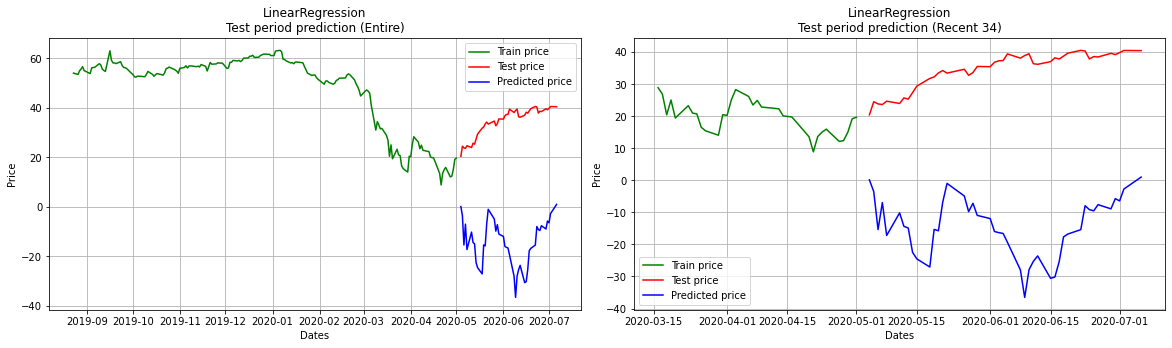

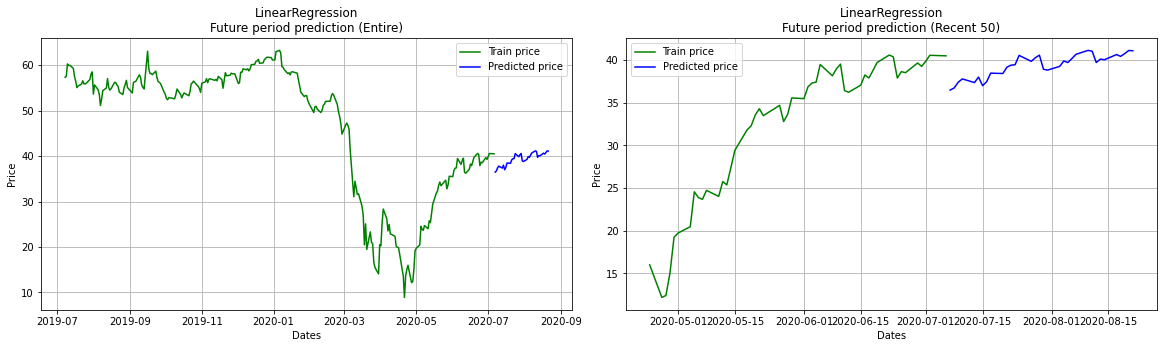

{'algorithm': 'Lasso', 'mse': 279.5198, 'mae': 15.178, 'rmse': 16.7188}


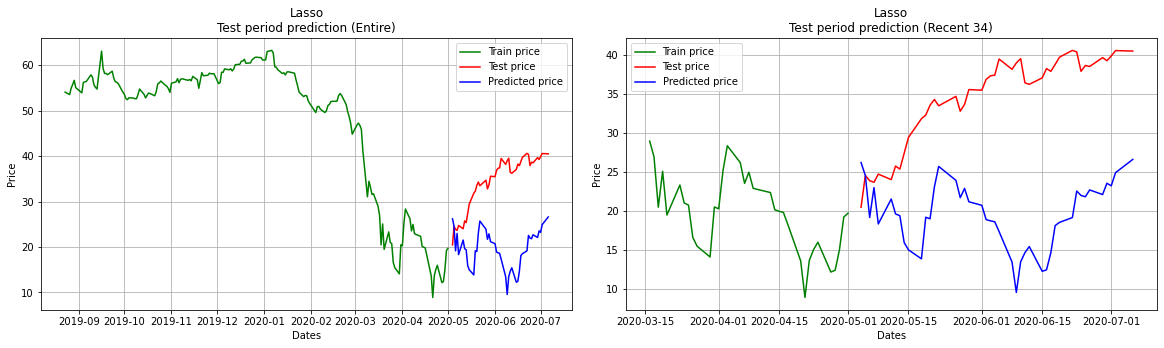

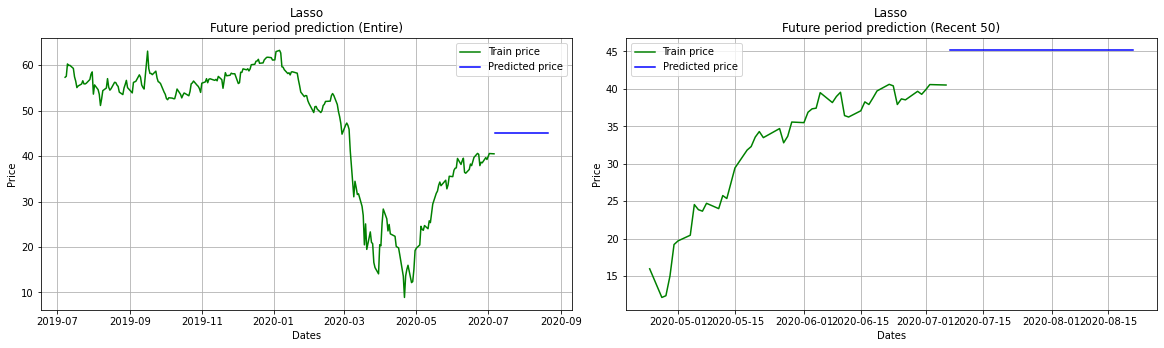

{'algorithm': 'ElasticNet', 'mse': 343.4294, 'mae': 17.0338, 'rmse': 18.5318}


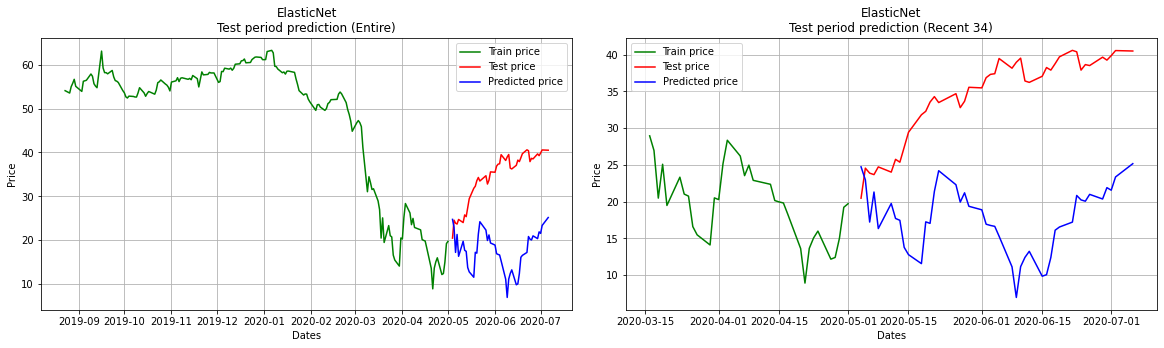

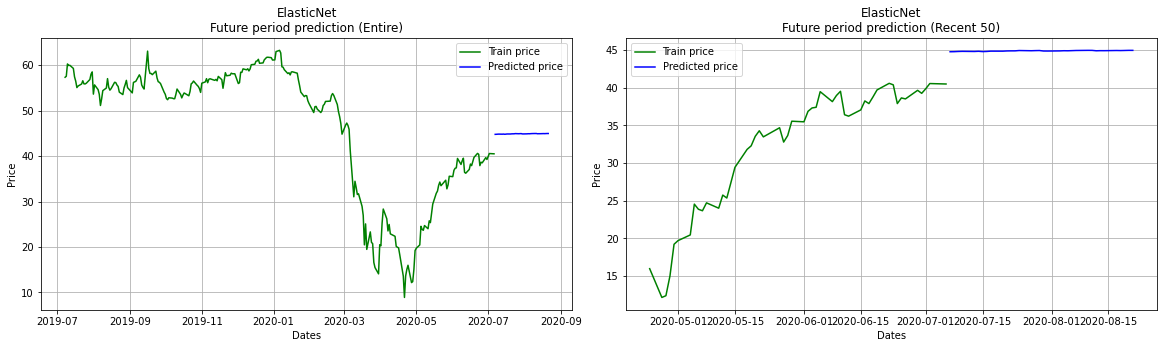

{'algorithm': 'SVR_linear', 'mse': 1058.1332, 'mae': 31.0261, 'rmse': 32.529}


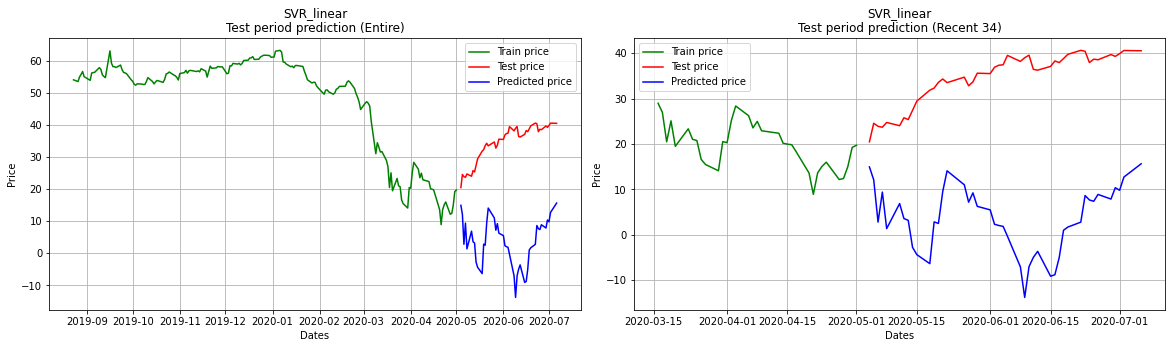

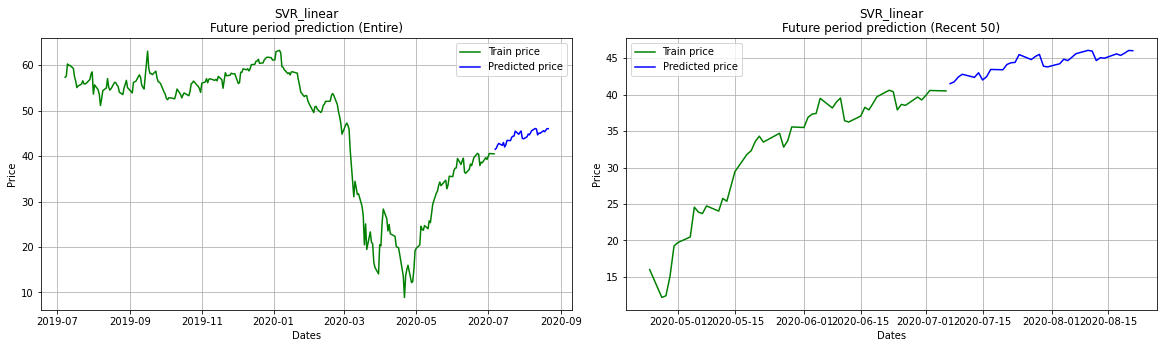

{'algorithm': 'TheilSenRegressor', 'mse': 56.439, 'mae': 6.3576, 'rmse': 7.5126}


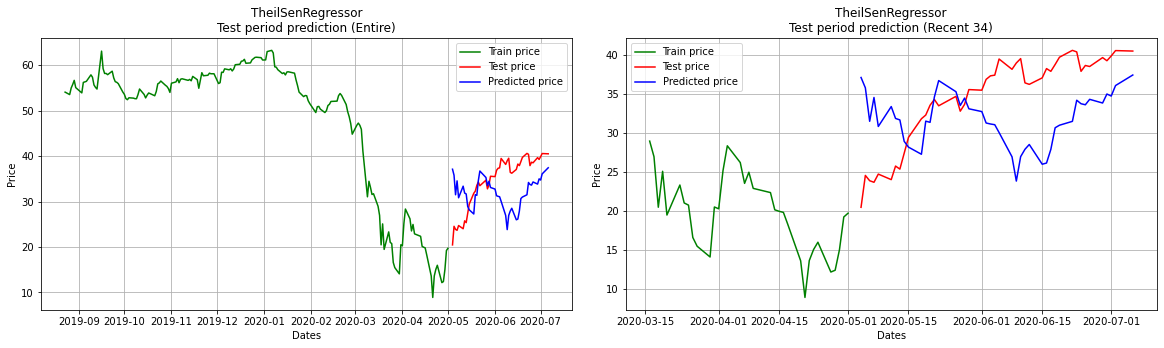

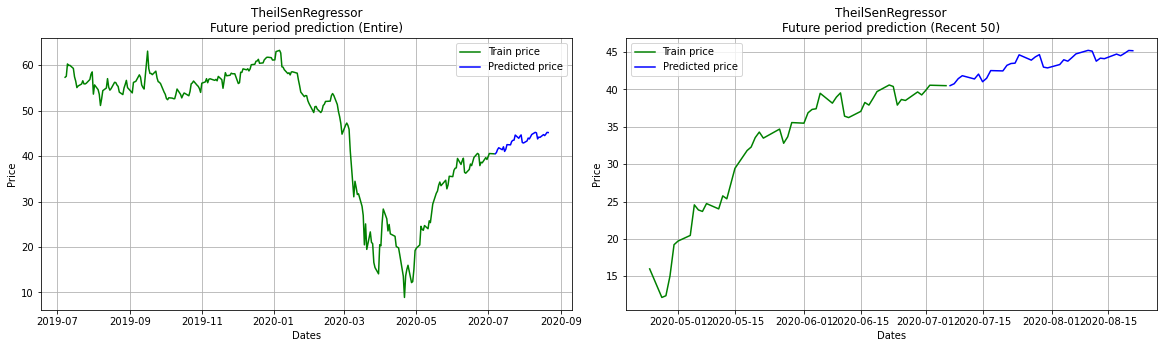

{'algorithm': 'RANSACRegressor', 'mse': 2001.1561, 'mae': 44.315, 'rmse': 44.7343}


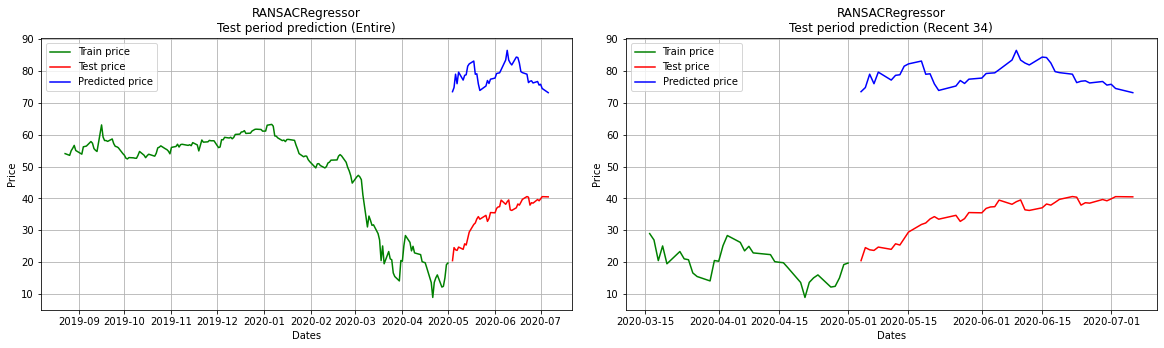

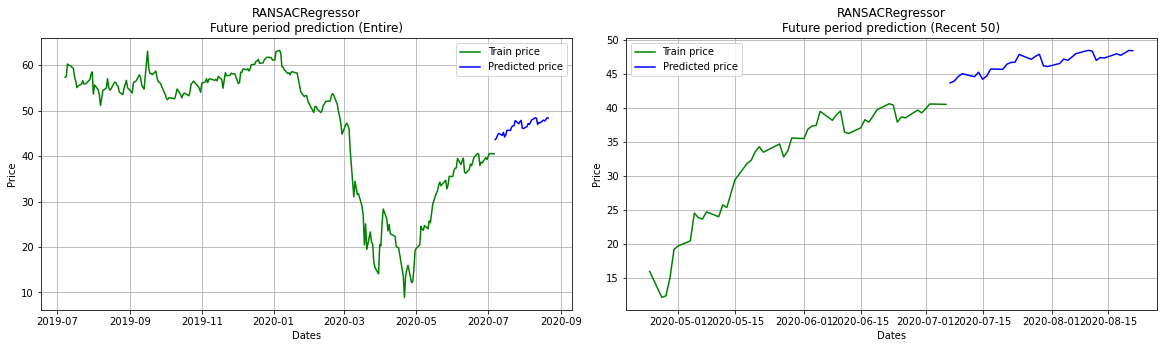

{'algorithm': 'HuberRegressor', 'mse': 1530.6807, 'mae': 37.7423, 'rmse': 39.1239}


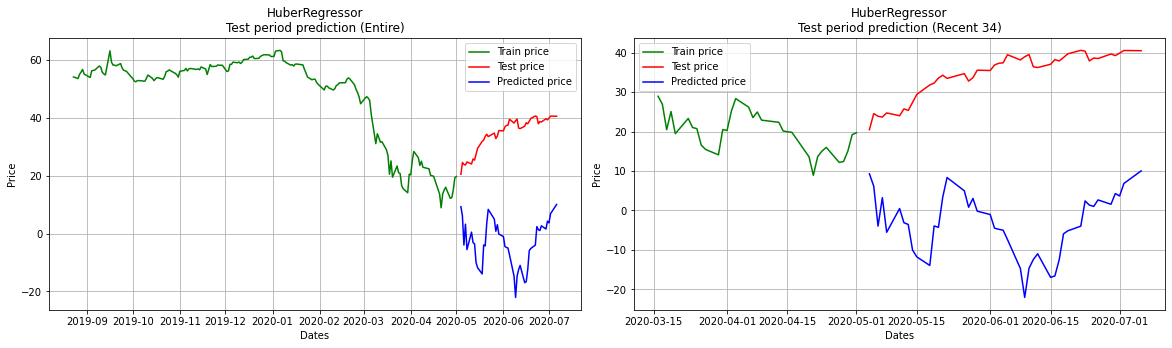

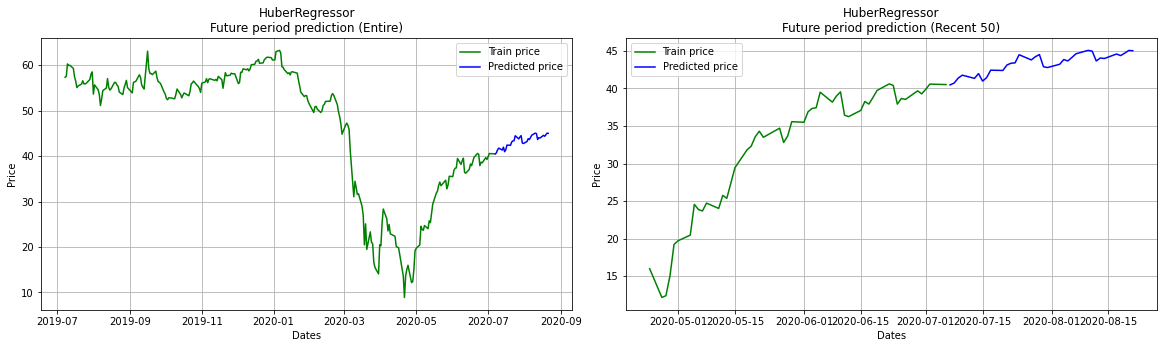

In [21]:
for reg_name, reg in reg_dict.items():

    # prepare data
    forecast_out = 34
    x_train, x_test, y_train, y_test, X_lately = prepare_data(data,forecast_out,0.2)

    # feature Scaling
    stdsc = StandardScaler()
    x_train_std = stdsc.fit_transform(x_train)
    y_train_std = stdsc.transform(y_train.reshape(-1, 1))
    x_test_std = stdsc.transform(x_test)
    y_test_std = stdsc.transform(y_test.reshape(-1, 1))

    # create and train model
    reg.fit(x_train_std, y_train_std)

    # Predict test period
    prediction = reg.predict(x_test_std)

    # inverse transform
    prediction = stdsc.inverse_transform(prediction.reshape((-1)))

    # calculate performance metrics
    acc = calculate_accuracy(prediction, y_test, reg_name)
    print(acc)
    acc_sum.append(acc)

    # show result
    future_dates1 = data.index[forecast_out:forecast_out+len(x_train)]
    future_dates2 = data.index[forecast_out+len(x_train):]
    df_train = pd.DataFrame({'Price':y_train},index=future_dates1)
    df_test = pd.DataFrame({'Price':y_test},index=future_dates2)
    df_pred = pd.DataFrame({'Price':prediction},index=future_dates2)
    show_graph(df_train,df_test,df_pred,title=reg_name+'\nTest period prediction')


    # prepare data
    forecast_out = 34
    x_train, x_test, y_train, y_test, X_lately = prepare_data(data,forecast_out,0.0)

    # feature Scaling
    stdsc = StandardScaler()
    x_train_std = stdsc.fit_transform(x_train)
    y_train_std = stdsc.transform(y_train.reshape(-1, 1))
    X_lately_std = stdsc.transform(X_lately)

    # create and train model
    reg.fit(x_train_std, y_train_std)

    # Predict future period
    prediction = reg.predict(X_lately_std)

    # inverse transform
    prediction = stdsc.inverse_transform(prediction.reshape((-1)))

    # show result
    future_dates = make_future_dates(data.index[-1], forecast_out)
    df_pred = pd.DataFrame({'Price':prediction},index=future_dates)
    show_graph(data,None,df_pred,title=reg_name+'\nFuture period prediction')

    df_preds[reg_name] = df_pred['Price']

# Evaluate performance metrics

In [4]:
df_sum = pd.DataFrame(acc_sum)
df_sum = df_sum.sort_values('mae', ascending=True)
df_sum = df_sum.reset_index(drop=True)
df_sum

NameError: name 'acc_sum' is not defined

# Visualize prediction results of each model

## Raw price

In [23]:
df_preds

,AR Model,MA Model,ARMA Model,ARIMA Model,Facebook Prophet,LSTM,LinearRegression,Lasso,ElasticNet,SVR_linear,TheilSenRegressor,RANSACRegressor,HuberRegressor
Date,,,,,,,,,,,,,
2020-07-07,40.583375,44.514662,40.548874,40.427501,41.951479,36.779004,36.490711,45.134194,44.793132,41.507177,40.512806,43.663240,40.465335
2020-07-08,40.655993,46.634095,40.639895,40.371080,42.121686,35.245147,36.740496,45.134194,44.802988,41.752094,40.765867,43.919230,40.711809
2020-07-09,40.727862,46.634095,40.689092,40.296788,42.292081,33.102541,37.410130,45.134194,44.829411,42.408681,41.444286,44.605503,41.372570
2020-07-10,40.798989,46.634095,40.769750,40.235403,42.462660,31.170766,37.803408,45.134194,44.844929,42.794296,41.842722,45.008553,41.760636
2020-07-13,40.869382,46.634095,40.824735,40.164756,42.633419,29.469733,37.372928,45.134194,44.827943,42.372204,41.406596,44.567377,41.335861
2020-07-14,40.939050,46.634095,40.898609,40.100760,42.804353,27.790062,38.015990,45.134194,44.853317,43.002736,42.058094,45.226417,41.970401
2020-07-15,41.007998,46.634095,40.956636,40.031988,42.975459,26.091025,37.006224,45.134194,44.813473,42.012644,41.035081,44.191561,40.974016
2020-07-16,41.076236,46.634095,41.025912,39.966646,43.146733,24.417489,37.468590,45.134194,44.831718,42.466002,41.503513,44.665416,41.430255
2020-07-17,41.143769,46.634095,41.085319,39.898841,43.318171,22.916601,38.478357,45.134194,44.871562,43.456094,42.526526,45.700272,42.426640


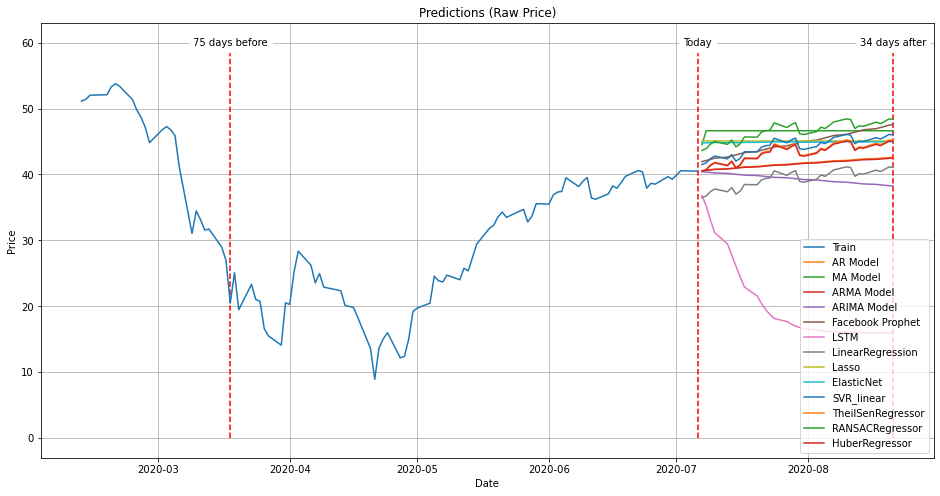

In [24]:
# display
plt.figure(figsize=(16, 8))
plt.plot(data.index[-100:], data['Price'].tail(100),label="Train")
for col in df_preds.columns:
    plt.plot(df_preds.index[-len(df_preds):], df_preds[col][-len(df_preds):],label=col)
    
plt.vlines([data.index[-1]], 0, 60, "red", linestyles='dashed')
plt.text([data.index[-1]], 60, 'Today', backgroundcolor='white', ha='center', va='center')
plt.vlines([data.index[-1-75]], 0, 60, "red", linestyles='dashed')
plt.text([data.index[-1-75]], 60, '75 days before', backgroundcolor='white', ha='center', va='center')
plt.vlines([df_preds.index[-1]], 0, 60, "red", linestyles='dashed')
plt.text([df_preds.index[-1]], 60, '34 days after', backgroundcolor='white', ha='center', va='center')

plt.title('Predictions (Raw Price)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='lower right',ncol=1)
plt.grid(True)
plt.show()

## MA75 Price
see also:<br>
https://www.kaggle.com/sajikim/moving-average-example-in-python

In [25]:
# ma75 calculation 
df_ma75 = df_org.copy() 
for col in df_preds.columns:
    df_ma75[col] = df_org['Price'].copy() 
df_ma75 = pd.concat([df_ma75, df_preds])
df_ma75 = df_ma75.rolling(75).mean()
df_ma75[-len(df_preds):]

,Price,AR Model,MA Model,ARMA Model,ARIMA Model,Facebook Prophet,LSTM,LinearRegression,Lasso,ElasticNet,SVR_linear,TheilSenRegressor,RANSACRegressor,HuberRegressor
Date,,,,,,,,,,,,,,
2020-07-07,NaN,27.657778,27.710195,27.657318,27.655700,27.676020,27.607053,27.603209,27.718456,27.713908,27.670096,27.656837,27.698843,27.656204
2020-07-08,NaN,27.940125,28.072250,27.939450,27.934248,27.977909,27.817255,27.833349,28.060512,28.051548,27.967057,27.940649,28.024700,27.939295
2020-07-09,NaN,28.172096,28.382971,28.170905,28.160472,28.230737,27.947556,28.021085,28.351234,28.338207,28.221439,28.182173,28.308373,28.179863
2020-07-10,NaN,28.435683,28.724359,28.434101,28.416544,28.516505,28.082766,28.244730,28.672624,28.655739,28.511630,28.459676,28.628087,28.456271
2020-07-13,NaN,28.703941,29.069481,28.701765,28.675407,28.808284,28.199029,28.466369,28.997746,28.976779,28.799926,28.735097,28.945652,28.730749
2020-07-14,NaN,29.028462,29.469935,29.025746,28.988751,29.157676,28.348230,28.751916,29.378202,29.353490,29.151962,29.074538,29.327338,29.069021
2020-07-15,NaN,29.368835,29.885323,29.365435,29.316110,29.524282,28.489710,29.038932,29.773591,29.744603,29.505731,29.415273,29.710158,29.408942
2020-07-16,NaN,29.728518,30.319111,29.724447,29.660999,29.911572,28.627277,29.350513,30.187381,30.154359,29.883944,29.780653,30.117697,29.773345
2020-07-17,NaN,30.003635,30.667432,29.998784,29.919517,30.215681,28.659365,29.590091,30.515703,30.479180,30.189892,30.074207,30.453568,30.065567


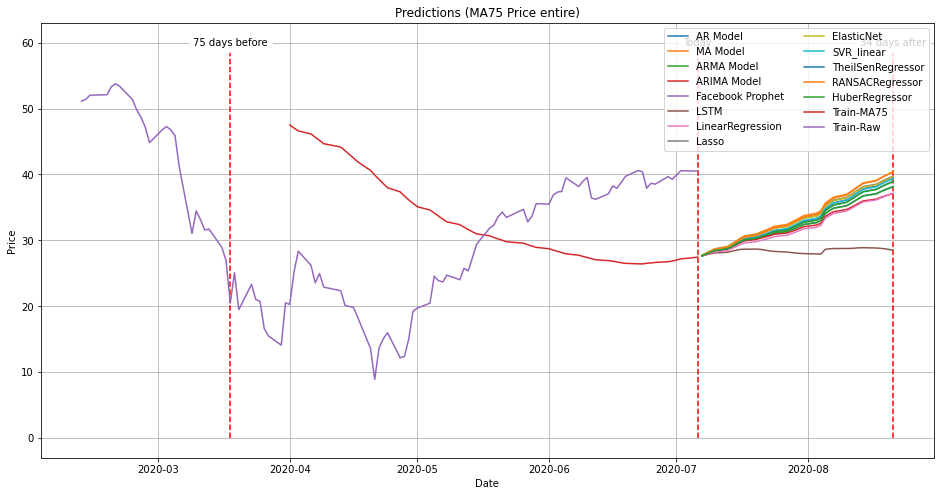

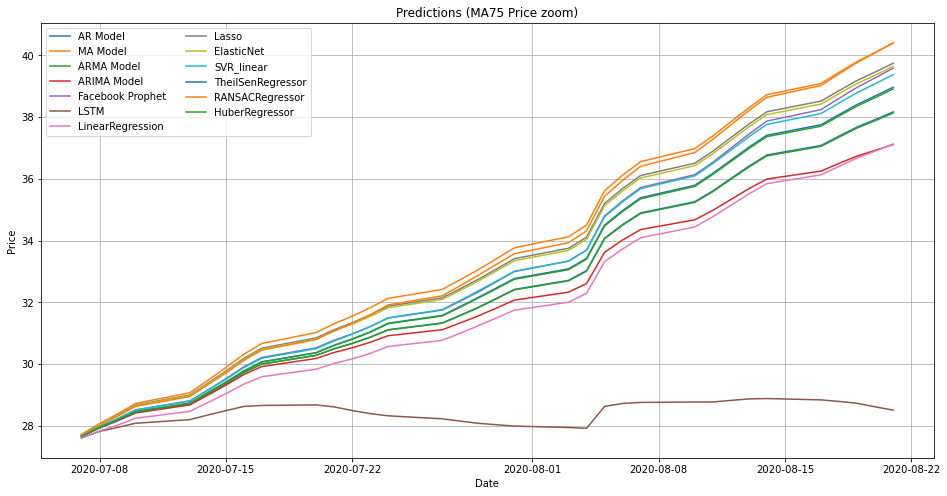

In [26]:
def disp_all(mode='entire'):
    plt.figure(figsize=(16, 8))
    for col in df_ma75.columns:
        if col != "Price":
            plt.plot(df_ma75.index[-len(df_preds):], df_ma75[col][-len(df_preds):],label=col)

    if mode is 'entire':
        plt.plot(df_ma75.index[-100:], df_ma75['Price'].tail(100),label="Train-MA75")
        plt.plot(data.index[-100:], data['Price'].tail(100),label="Train-Raw")
        plt.vlines([data.index[-1]], 0, 60, "red", linestyles='dashed')
        plt.text([data.index[-1]], 60, 'Today', backgroundcolor='white', ha='center', va='center')
        plt.vlines([data.index[-1-75]], 0, 60, "red", linestyles='dashed')
        plt.text([data.index[-1-75]], 60, '75 days before', backgroundcolor='white', ha='center', va='center')
        plt.vlines([df_ma75.index[-1]], 0, 60, "red", linestyles='dashed')
        plt.text([df_ma75.index[-1]], 60, '34 days after', backgroundcolor='white', ha='center', va='center')

    plt.title('Predictions (MA75 Price '+mode+')')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend(loc='best',ncol=2)
    plt.grid(True)
    plt.show()
    
disp_all('entire')
disp_all('zoom')

# Creating submission file

In [27]:
template = pd.read_csv('../input/ntt-data-global-ai-challenge-06-2020/sampleSubmission0710_updated.csv', header=0, parse_dates=[0])
template.drop("Price",axis=1,inplace=True)

for col in df2.columns:
    submission = pd.merge(template, df2[col], on='Date', how='left')
    submission.rename(columns={col: 'Price'},inplace=True)
    if submission["Price"].isnull().any():
        #print("[Warning] NaN found in " + col +  " ("+str(submission["Price"].isnull().sum()) + ")")
        submission["Price"].fillna(submission["Price"].mean(),inplace=True)
    submission["Price"] = submission["Price"].round(9)
    submission.to_csv("submission_" + col + ".csv", index=False)

NameError: name 'df2' is not defined

Thank you for your reading!
Good luck!